# Figure 3

In [2]:
# Load Function Definitions 

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap

from itertools import combinations
from sklearn.metrics import auc, roc_curve
from thymmatu.graphics.pro_plot import heatmap_table

font = {'size' : 8}
matplotlib.rc('font', **font)

#  standards  #
#  standards WEIZMANN jupyter #
from standards import *

DataPath = "Data"
OutPath = "Graphs"

## AUC Heatmap

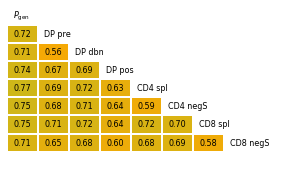

In [6]:
colors = ["#ffa600", "#a5c630"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)
norm1 = Normalize(vmin=0.5, vmax=1.0)

font = {'size'   : 8}
matplotlib.rc('font', **font)

labelList = ['gen'] + CC_VEC
AUC = pd.DataFrame(columns=[CC_to_HEAD[lab] for lab in labelList],
                index=[CC_to_HEAD[lab] for lab in labelList],
                dtype=float)

# run over all cascade checkpoints
for LabPos, LabNeg in list( combinations( labelList, 2 ) ) :    

    kerasPath = f'{DataPath}/CA-linear_models/mk-{LabPos}-{LabNeg}-CA-prod'
    df = pd.read_csv( f"{kerasPath}/test-prediction.csv.gz", compression='gzip' )
        
    y_test = df['y_test'].values
    y_pred = df['y_pred'].values

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    AUC.at[CC_to_HEAD[LabPos],CC_to_HEAD[LabNeg]] = auc(fpr,tpr)

AUC = AUC.transpose()
ax = heatmap_table( AUC, cmap=cmap1, norm=norm1, figsize=(5,3), digits=2, diagonal=True )
plt.savefig( f"{OutPath}/fig3A.pdf", bbox_inches='tight', dpi=300 )

## Collective Regression
CD4 spl vs CD4 negS

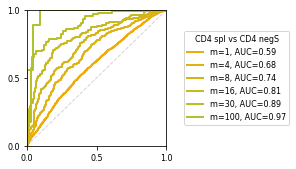

In [13]:
LabPos = 'CD4_spl'
LabNeg = 'CD4_negS'
kerasPath = f"{DataPath}/CA-linear_models/mk-{LabPos}-{LabNeg}-CA-prod"
df = pd.read_csv( f"{kerasPath}/test-prediction.csv.gz", compression='gzip' )

y_test = df['y_test'].values
y_pred = df['y_pred'].values

y_pred_pos = y_pred[ y_test == 1 ]
np.random.shuffle(y_pred_pos)
y_pred_neg = y_pred[ y_test == 0 ]
np.random.shuffle(y_pred_neg)

plt.figure(figsize=(2.5,2.5))

m_List = [1, 4, 8, 16, 30, 100 ]
for i, M in enumerate( m_List ) :

    # < + > #
    n_pos = int(np.floor(len(y_pred_pos)/M))
    y_pred_pos_collec = np.prod( y_pred_pos[:n_pos*M].reshape(n_pos,M), axis=1 )

    # < - > #
    n_neg = int(np.floor(len(y_pred_neg)/M))
    y_pred_neg_collec = np.prod( y_pred_neg[:n_neg*M].reshape(n_neg,M), axis=1 )

    # test - M #
    y_pred_collec = np.concatenate( [y_pred_pos_collec, y_pred_neg_collec] )
    y_test_collec = np.concatenate( [np.ones(len(y_pred_pos_collec)), np.zeros(len(y_pred_neg_collec))] )

    fpr, tpr, thresholds = roc_curve(y_test_collec, y_pred_collec)
    
    this_auc = auc(fpr, tpr)
    this_color = cmap1( norm1(this_auc) )
    label = f"m={M}, AUC={np.round(this_auc,2):.2f}"
    plt.plot( fpr, tpr, color=this_color, lw=2, label=label )

plt.plot( fpr, fpr, ls="--", lw=1, color = GREYS_DIC["silver"], zorder=-10 )

Title = f'{CC_to_HEAD[LabPos]} vs {CC_to_HEAD[LabNeg]}'
plt.legend(title= Title, loc="center left",ncol=1,bbox_to_anchor=(1.1,.5))

plt.xlim([0,1])
plt.ylim([0,1])
plt.xticks([0.0, 0.5, 1.0])
plt.yticks([0.0, 0.5, 1.0])

plt.savefig( f"{OutPath}/fig3B.pdf", bbox_inches='tight', dpi=300 )
